<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>

</center>

# [Scénarios d'Apprentissage Statistique](https://github.com/wikistat/Apprentissage)



# Gestion des données manquantes sur les données d'Ozone avec  <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a>  <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-learn"/></a>

**Résumé**: 
- Création d'un jeu de données contenant des données manquantes à partir des données ozone 
- Visualisation des données manquantes 
- Comparaison de diverses méthodes de complétion pour les données quantitatives
- Complétion avec MissForest de l'ensemble des données (quantitaives et qualitatives) et impact sur les résultats de classification relativement au jeu de données initial complet

## Prise en charge des données </font>
### Lesture des données

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes:

* **JOUR** Le type de jour ; férié (1) ou pas (0) ;
* **O3obs** La concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** Prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** Température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** Rapport d'humidité ;
* **NO2** Concentration en dioxyde d'azote ;
* **NO** Concentration en monoxyde d'azote ;
* **STATION** Lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** Force du vent ;
* **VentANG** Orientation du vent. 

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent avant tout un caractère pédagogique.

Il est choisi ici de lire les données avec la librairie `pandas` pour bénéficier de la classe DataFrame. Ce n'est pas nécessaire pour l'objectif de prévision car les variables qualitatives ainsi construites ne peuvent être utilisées pour l'interprétation des modèles obtenus dans `scikit-learn` qui ne reconnaît pas la classe DataFrame.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Lecture des données
## Charger les données ou les lire directement en précisant le chemin
path=""
ozone=pd.read_csv(path+"depSeuil.dat",sep=",",header=0)
# Vérification du contenu
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
0,1,91,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
1,1,100,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
2,0,82,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
3,0,94,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
4,0,107,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822


Ce qui suit permet d'affecter le bon type aux variables.

In [2]:
ozone["STATION"]=pd.Categorical(ozone["STATION"],ordered=False)
ozone["JOUR"]=pd.Categorical(ozone["JOUR"],ordered=False)
ozone["O3obs"]=pd.DataFrame(ozone["O3obs"], dtype=float)
ozone.dtypes

JOUR       category
O3obs       float64
MOCAGE      float64
TEMPE       float64
RMH2O       float64
NO2         float64
NO          float64
STATION    category
VentMOD     float64
VentANG     float64
dtype: object

In [3]:
ozone.describe()

,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,VentMOD,VentANG
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
mean,115.400576,127.219693,23.883381,0.010251,3.504645,0.657417,5.907186,0.163111
std,40.999155,39.820186,5.217462,0.003731,4.043308,0.844180,3.054307,0.708288
min,19.000000,46.400000,10.400000,0.002850,0.258000,0.001000,0.141420,-1.570790
25%,87.000000,97.500000,20.200000,0.007630,1.248000,0.236000,3.962320,-0.394790
50%,109.000000,125.600000,23.800000,0.009850,2.109000,0.388000,5.597300,0.278300
75%,135.000000,153.600000,27.600000,0.012440,4.062000,0.744000,7.106300,0.692640
max,319.000000,284.700000,38.000000,0.027530,44.396000,9.429000,19.891000,1.570790


### Transformations des données

In [4]:
from math import sqrt, log
ozone["SRMH2O"]=ozone["RMH2O"].map(lambda x: sqrt(x))
ozone["LNO2"]=ozone["NO2"].map(lambda x: log(x))
ozone["LNO"]=ozone["NO"].map(lambda x: log(x))
del ozone["RMH2O"]
del ozone["NO2"]
del ozone["NO"]


In [5]:
ozone["DepSeuil"]=ozone["O3obs"].map(lambda x: x > 150)
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
0,1,91.0,93.2,21.5,Aix,9.5000,-0.64350,0.092033,0.471253,-0.858022,False
1,1,100.0,104.6,20.2,Aix,8.0100,-0.04996,0.093862,0.751888,-0.632993,False
2,0,82.0,103.6,17.4,Aix,9.3771,-0.12832,0.097519,0.505009,-0.761426,False
3,0,94.0,94.8,18.8,Aix,9.4578,-0.34516,0.092466,0.854415,-0.355247,False
4,0,107.0,99.0,23.7,Aix,7.8791,-0.41822,0.085499,0.502592,-0.794073,False


In [6]:
# variable à expliquer binaire
Yb=ozone["DepSeuil"].map(lambda x: int(x))


### Séparation des variables quantitatives et qualitatives

In [7]:
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
0,1,91.0,93.2,21.5,Aix,9.5000,-0.64350,0.092033,0.471253,-0.858022,False
1,1,100.0,104.6,20.2,Aix,8.0100,-0.04996,0.093862,0.751888,-0.632993,False
2,0,82.0,103.6,17.4,Aix,9.3771,-0.12832,0.097519,0.505009,-0.761426,False
3,0,94.0,94.8,18.8,Aix,9.4578,-0.34516,0.092466,0.854415,-0.355247,False
4,0,107.0,99.0,23.7,Aix,7.8791,-0.41822,0.085499,0.502592,-0.794073,False


In [8]:
# Variables explicatives
# On transforme les variables qualitatives en paquets d'indicatrice pour la phase d'apprentissage.

ozoneDum=pd.get_dummies(ozone[["JOUR","STATION"]])
del ozoneDum["JOUR_0"]
ozoneQuant=ozone[["MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]]

dfC=pd.concat([ozoneDum,ozoneQuant],axis=1)
dfC.head()

,JOUR_1,STATION_Aix,STATION_Als,STATION_Cad,STATION_Pla,STATION_Ram,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,1,1,0,0,0,0,93.2,21.5,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,1,1,0,0,0,0,104.6,20.2,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,0,1,0,0,0,0,103.6,17.4,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,0,1,0,0,0,0,94.8,18.8,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,0,1,0,0,0,0,99.0,23.7,7.8791,-0.41822,0.085499,0.502592,-0.794073


In [9]:
ozoneQuant.head()

,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,93.2,21.5,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,104.6,20.2,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,103.6,17.4,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,94.8,18.8,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,99.0,23.7,7.8791,-0.41822,0.085499,0.502592,-0.794073


## [Gestion des données manquantes](http://wikistat.fr/pdf/st-m-app-idm.pdf)
Les vraies données sont le plus souvent mitées par l'absence de données, conséquences d'erreurs de saisie, de pannes de capteurs... Les librairies de Python (`pandas`) offrent des choix rudimentaires pour faire des imputations de données manquantes quand celles-ci le sont de façon complètement aléatoire. 

Le calepin R d'analyse de ces mêmes données propose une comparaison assez détaillée de deux stratégiées afin d'évaluer leurs performances respectives. 

La **première stratégie** commence par imputer les données manquantes en les prévoyant par l'algorithme `missForest`. Une fois les données manquantes imputées, on utilise les forêts aléatoires pour construire un algorithme de prédiction du dépassement du seuil.

La **deuxième stratégie** évite l'étape d'imputation en exécutant directement un algorithme de prévision tolérant des données manquantes. Peu le font, c'est le cas de `XGBoost`.

Sur ces données, mais sans gros effort d'optimisation de `XGBoost`, la première stratégie enchaînant `missForest` puis `randomForest` conduit à de meilleurs résultats. Seule celle-ci est employée dans ce calepin mais, bien évidemment, l'exécution de `xgboost` sans imputation préalable est une option également possible en Python.

Bien moins de méthodes sont proposées en Python, `Scikit-learn` ne proposant que des imputations basiques par la moyenne ou la médiane comme dans `pandas`. Néanmoins une imputation par prévision utilisant *k*-nn,  ou des forêts aléatoires (Missforest) est disponible dans la librairie `sklearn.impute`. Le souci est que Python ne gère pas bien les deux types de variables : quantitatives et qualitatives. Pour simplifier dans ce TP, nous allons donc ne considérer des données manquantes que dans les variables quantitatives. 

Les commandes ci-dessous font appel aux fichiers suivants:
- `X` données complètes initiales : **ozoneQuant**
- `Xna` les données avec des trous, 
- `XnaImp` les données avec imputations 


### Préparation des trous dans `ozone`
Les variables explicatives quantitatives de la base `ozone` sont reprises. La première opération consiste à générer aléatoirement un certain taux de données manquantes par la fonction définie ci-dessous.

In [10]:
import numpy as np
import numpy.ma as ma
import random

def input_nan(x, tx):
    """
    x : a 2D matrix of float dtype
    tx: the rate of nan value to put in the matrix
    """
    n_total = x.shape[0] * x.shape[1]
    mask = np.array([random.random() for _ in range(n_total)]).reshape(x.shape)<tx
    mx = ma.masked_array(x, mask=mask, fill_value=np.nan)
    return mx.filled()

In [11]:
# données initiales 
X=ozoneQuant 
# Génération de 30% de valeurs manquantes
Xna=input_nan(X, .3)

Xna_df = pd.DataFrame(Xna, columns=ozoneQuant.columns)

Xna_df.head()

,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,93.2,21.5,NaN,NaN,0.092033,0.471253,NaN
1,104.6,NaN,NaN,-0.04996,0.093862,0.751888,-0.632993
2,103.6,NaN,9.3771,NaN,0.097519,0.505009,NaN
3,94.8,18.8,NaN,NaN,0.092466,0.854415,NaN
4,99.0,NaN,NaN,NaN,0.085499,0.502592,-0.794073


### Visualisation des données manquantes

In [12]:
nrows = len(Xna)
missing_rates = 1-Xna_df.count(axis=0)/nrows
missing_rates

MOCAGE     0.263208
TEMPE      0.304515
VentMOD    0.292988
VentANG    0.286263
SRMH2O     0.301633
LNO2       0.291066
LNO        0.309318
dtype: float64

<Axes: >

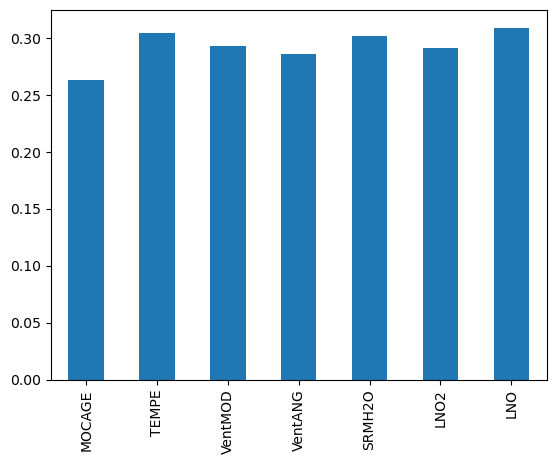

In [13]:
missing_rates.plot.bar()

## Imputation  des données manquantes

### Imputation simple

In [14]:
from sklearn.impute import SimpleImputer

X_mean = SimpleImputer().fit_transform(Xna)


**Question** Regarder quelles sont les options proposées par SimpleImputer. Quelle est l'option par défaut utilisée ci dessus ?

In [15]:
X_meanImp=pd.DataFrame(X_mean, columns=ozoneQuant.columns)

In [16]:
X_meanImp.head()

,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,93.2,21.500000,5.893473,0.160272,0.092033,0.471253,-0.844047
1,104.6,23.877348,5.893473,-0.049960,0.093862,0.751888,-0.632993
2,103.6,23.877348,9.377100,0.160272,0.097519,0.505009,-0.844047
3,94.8,18.800000,5.893473,0.160272,0.092466,0.854415,-0.844047
4,99.0,23.877348,5.893473,0.160272,0.085499,0.502592,-0.794073


**Question** Sur la variable 'Température', reprendre l'analyse qui avait été faite en R : boxplot des erreurs d'imputation avec les diverses méthodes (moyenne, médiane, ..)

### Imputation avec KNN

In [17]:
from sklearn.impute import  KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
X_kNN = knn_imputer.fit_transform(Xna)

In [18]:
X_kNNImp=pd.DataFrame(X_kNN, columns=ozoneQuant.columns)

In [19]:
X_kNNImp.head()

,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,93.2,21.50,6.263104,-0.239562,0.092033,0.471253,-1.224513
1,104.6,23.46,6.704960,-0.049960,0.093862,0.751888,-0.632993
2,103.6,27.16,9.377100,-0.305544,0.097519,0.505009,-1.010223
3,94.8,18.80,6.263104,0.101684,0.092466,0.854415,-0.964573
4,99.0,22.78,7.592966,-0.177184,0.085499,0.502592,-0.794073


### Imputation par `missForest`

L'estimateur *ExtraTreesRegressor* entraîne une forêt aléatoire itérative et imite *missForest* dans R. *ExtraTreesRegressor* ajuste un certain nombre d'arbres aléatoires  et calcule la moyenne des résultats. Il provient du module sklearn.ensemble. Ses principaux arguments sont le nombre d'arbres dans la forêt et l'état aléatoire qui permet de contrôler les sources d'aléa.  Regarder l'aide pour plus de précisions.

In [32]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [33]:
estimator_rf = ExtraTreesRegressor(n_estimators=20, random_state=0)
X_rf = IterativeImputer(estimator=estimator_rf, random_state=0, max_iter=300).fit_transform(Xna)


/usr/local/insa/anaconda/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [24]:
ozoneQuant.head()

,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,93.2,21.5,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,104.6,20.2,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,103.6,17.4,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,94.8,18.8,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,99.0,23.7,7.8791,-0.41822,0.085499,0.502592,-0.794073


## Comparaison des erreurs de prévision par forêt aléatoire
Prévision du dépassement d'ozone sans données manquantes et avec données manquantes imputées. Comparaison des erreurs de prévision sur l'échantillon test. Les valeurs par défaut des paramètres sont conservées. 
### Prévision sans données manquantes

Extractions des échantillons d'apprentissage  et test. Comme le générateur est initalisé de façon identique, ce sont les mêmes échantillons dans les deux cas.

In [25]:
from sklearn.model_selection import train_test_split  
X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=200,random_state=11)


In [26]:
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(X_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(X_test)

In [27]:
from sklearn.ensemble import RandomForestClassifier 
# prévision sans trous
forest = RandomForestClassifier(n_estimators=500)
# apprentissage
rfFit = forest.fit(Xr_train,Yb_train)
# erreur de prévision
# erreur de prévision sur le test
1-rfFit.score(Xr_test,Yb_test)

0.10999999999999999

### Prévision après imputation des données manquantes

In [28]:
dfCImp=pd.concat([ozoneDum,X_rfImp],axis=1)
dfCImp.head()

,JOUR_1,STATION_Aix,STATION_Als,STATION_Cad,STATION_Pla,STATION_Ram,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,1,1,0,0,0,0,93.2,21.500,5.724836,0.015698,0.092033,0.471253,-0.992519
1,1,1,0,0,0,0,104.6,19.885,5.537961,-0.049960,0.093862,0.751888,-0.632993
2,0,1,0,0,0,0,103.6,22.870,9.377100,-0.398519,0.097519,0.505009,-1.002856
3,0,1,0,0,0,0,94.8,18.800,4.593560,0.711467,0.092466,0.854415,-0.725443
4,0,1,0,0,0,0,99.0,19.970,4.398523,0.717913,0.085499,0.502592,-0.794073


In [29]:
from sklearn.model_selection import train_test_split  
XnaImp_train,XnaImp_test,Yb_train,Yb_test=train_test_split(dfCImp,Yb,test_size=200,random_state=11)


In [30]:
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(XnaImp_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(XnaImp_test)

In [31]:
# prévision avec trous imputés
forest = RandomForestClassifier(n_estimators=500)
# apprentissage
rfFit = forest.fit(XnaImp_train,Yb_train)
# erreur de prévision
# erreur de prévision sur le test
1-rfFit.score(XnaImp_test,Yb_test)

0.14

**Question** Que dire de la qualité de prévision avec 30% de données manquantes ? Comparer avec ce qui est obtenu pour les autres types d'imputation.

Faites varier ce taux et étudiez la dégradation de la prévision.




In [23]:
X_rfImp.head()

,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,93.2,21.500,5.724836,0.015698,0.092033,0.471253,-0.992519
1,104.6,19.885,5.537961,-0.049960,0.093862,0.751888,-0.632993
2,103.6,22.870,9.377100,-0.398519,0.097519,0.505009,-1.002856
3,94.8,18.800,4.593560,0.711467,0.092466,0.854415,-0.725443
4,99.0,19.970,4.398523,0.717913,0.085499,0.502592,-0.794073
